# Last class I showed you a visualization of a neural network output. Let's visualize some genetic programs the same way.

In [1]:
import numpy as np
#let's ignore overflow warnings from numpy in case we get
#big numbers, no biggy.
np.seterr(over='ignore', divide='raise')
import random
from matplotlib import pyplot

## Here's the neural network visualization, for reference. 

## This is just copy+pasted from our last worksheet on neuroevolution.

In [2]:
class SimpleNeuralNet():
    #this is our squashing function
    def activation_function(self, x):
        return 1/(1+np.exp(-x))
    
    #this should look familiar, just a way to create a copy of 
    #the network without worying about pesky reference 
    def deepcopy(self):
        new_net = SimpleNeuralNet(self.num_inputs, self.num_outputs, self.layer_node_counts)
        new_net.layers = [np.copy(layer) for layer in self.layers]
        return new_net
    
    #this is where the neural network does its computation!
    def execute(self, input_vector):
        # First we need to make sure we're getting the right
        # number of inputs into our neural network.
        assert len(input_vector) == self.num_inputs ,\
        "wrong input vector size"

        # create a temporary variable to hold the values that should go
        # into the next layer of the network.
        # **at the start, this will just be our input**
        next_v = input_vector

        # iterate through layers, computing the activation
        # of the weighted inputs from the previous layer
        for layer in self.layers:
            # add a bias to each layer [1]
            next_v = np.append(next_v, 1)
            
            # pump the input vector through the matrix multiplication
            # and our activation function
            next_v = self.activation_function(np.dot(next_v, layer))
            
        return next_v
        
    def __init__(self, num_inputs, num_outputs, layer_node_counts=[]):
        self.num_inputs = num_inputs
        self.layer_node_counts = layer_node_counts
        self.num_outputs = num_outputs
        self.layers = []
        
        last_num_neurons = self.num_inputs
        for nc in layer_node_counts + [num_outputs]:
            # for now, we'll just use random weights in the range [-5,5]
            # +1 handles adding a bias node for each layer of nodes
            self.layers.append(np.random.uniform(-5, 5, size=(last_num_neurons+1, nc)))
            last_num_neurons = nc
    

## This is the loop also from the last worksheet, but just the new part I added today. 
### Try added some hidden nodes!

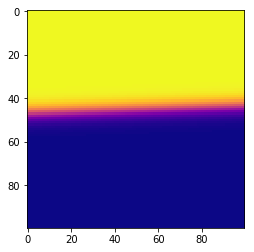

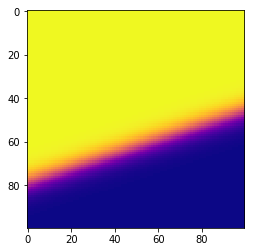

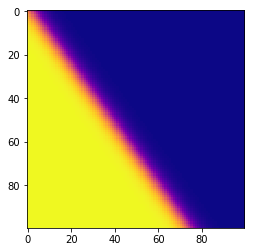

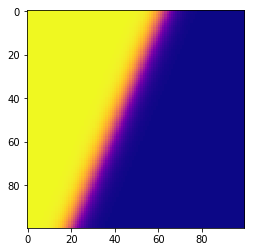

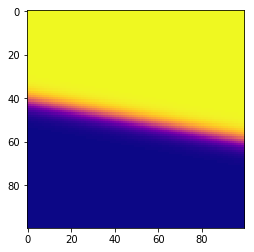

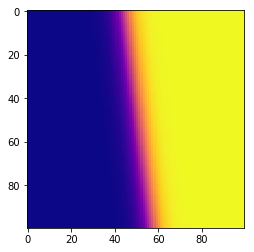

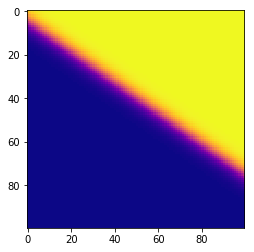

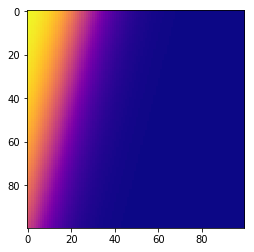

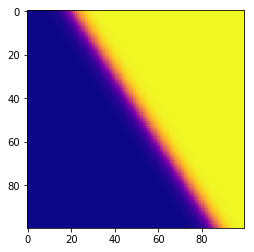

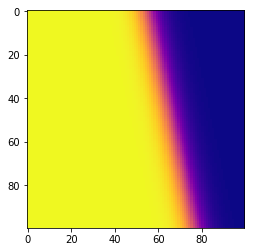

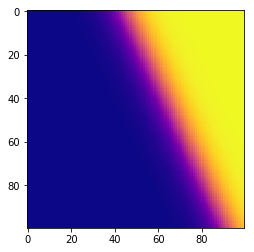

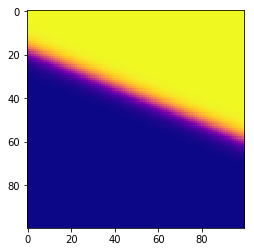

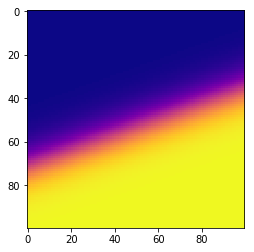

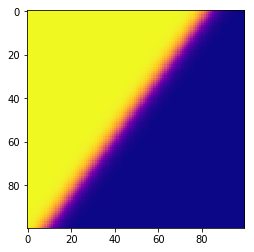

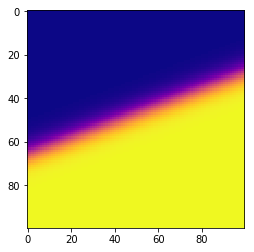

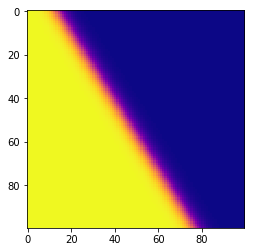

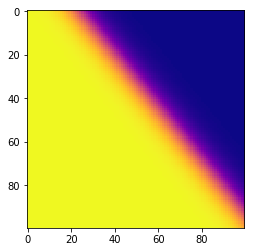

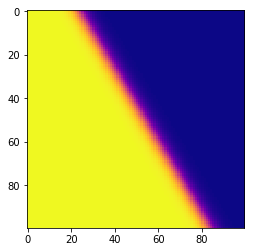

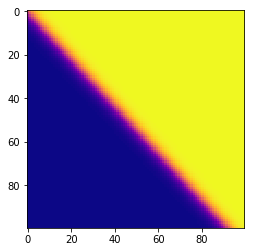

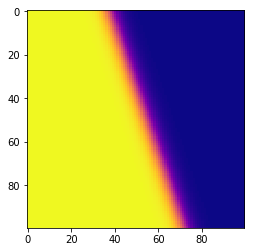

In [3]:
for i in range(20):
    g = SimpleNeuralNet(num_inputs=2, num_outputs=1, layer_node_counts=[])
    #get 20 values between 0 and 1 for both x and y inputs
    x = y = np.linspace(-5,5,100)

    #make a 20x20 matrix of all zeros
    mat_img = np.zeros((100, 100))

    for i in range(100):
        for j in range(100):
            #plot the 0th individual in the population's "phenotype"
            mat_img[i,j] = g.execute([x[i],y[j]])[0]

    pyplot.imshow(mat_img, cmap=pyplot.get_cmap("plasma"))
    pyplot.show()

# This monster chunk of code is from our Genetic Programing worksheet (remember wayyyy back when we were working on that?). 

# We can do the same sort of visualization with a randomly grown program, if we give it an `x` and a `y` terminal node (remember what those are?). 

In [4]:
class GPNode:
    def __init__(self, node_type=None):
        self.parent = None
        self.node_type = node_type
        self.children = []
        self.depth = 0
        
    def add_child(self, child_node):
        child_node.depth = self.depth+1
        self.children.append(child_node)
        child_node.parent = self
    
    
class GPConstNode(GPNode):
    def __init__(self, value=None):
        super().__init__(node_type="Const")
        self.const_value = value
    
    def evaluate(self, input_state):
        return self.const_value
        
    def pretty_print(self, indents=0):
        print('  '*indents + str(self.const_value) 
              + ' : ' + str(self.depth))
        
    def deepcopy(self):
        new_node = GPConstNode(value=self.const_value)
        new_node.depth = self.depth;
        return new_node
        
        
class GPVariableNode(GPNode):
    def __init__(self, variable_name=None):
        super().__init__(node_type="Variable")
        self.variable_name = variable_name
    
    def evaluate(self, input_state):
        return input_state[self.variable_name]
    
    def pretty_print(self, indents=0):
        print('  '*indents + str(self.variable_name)
              + ' : ' + str(self.depth))
        
    def deepcopy(self):
        new_node = GPVariableNode(variable_name = self.variable_name)
        new_node.depth = self.depth
        return new_node
        
class GPFunctionNode(GPNode):
    def __init__(self, arg_count, func_name=None, gp_function=None):
        super().__init__(node_type="Function")
        self.argument_count = arg_count
        self.gp_function = gp_function
        self.function_name = func_name
        
    def evaluate(self, input_state): 
        assert self.argument_count == len(self.children), \
        'Number of child nodes must match argument count'

        child_results = [c.evaluate(input_state) for c in self.children]
        return self.gp_function(*child_results)

    def pretty_print(self, indents=0):
        print('  '*indents + str(self.function_name) 
              + ' : ' + str(self.depth))
        
        for child in self.children:
            child.pretty_print(indents+1)
        
    def deepcopy(self):
        new_node = GPFunctionNode(self.argument_count, 
                                   self.function_name, 
                                   self.gp_function)
        new_node.depth = self.depth
        
        for child in self.children:
            new_node.add_child(child.deepcopy())
        
        return new_node

class GPIndividual:
    def grow_random(self, cur_node=None, cur_depth=0):
        if (random.random() < self.prob_terminal 
            or cur_depth == self.max_genotype_depth-1):
            new_node = random.choice(self.terminal_set).deepcopy()
            new_node.parent = cur_node
            new_node.depth = cur_depth
        else:
            new_node = random.choice(self.function_set).deepcopy()
            new_node.depth = cur_depth
            new_node.parent = cur_node
            for i in range(new_node.argument_count):
                new_node.add_child(self.grow_random(cur_node=new_node, 
                                                    cur_depth=cur_depth+1))
        return new_node
    
    
    def __init__(self, function_set, terminal_set, 
                 prob_terminal=0.2, max_depth=5, num_output=1):
        self.max_genotype_depth = max_depth
        self.fitness = None
        self.function_set = function_set
        self.terminal_set = terminal_set
        self.prob_terminal = prob_terminal
        self.num_output = num_output
        
        if self.num_output == 1 :
            self.genotype = self.grow_random()
        else:
            self.genotype = [self.grow_random() for _ in range(self.num_output)]
    def pretty_print(self):
        self.genotype.pretty_print()
        
    def deepcopy(self):
        new_individual = GPIndividual(self.function_set, 
                                      self.terminal_set, 
                                      self.prob_terminal, 
                                      self.max_genotype_depth)
        new_individual.genotype = self.genotype.deepcopy()
        return new_individual

    
    def visit_genotype_nodes(self, cur_node=None):
        if cur_node == None: 
            cur_node = self.genotype
            
        node_list = [cur_node]
        visitor_index = 0
        
        while visitor_index < len(node_list):
            if len(node_list[visitor_index].children) > 0:
                node_list.extend(node_list[visitor_index].children)
            visitor_index += 1
            
        return node_list
            
    def mark_depths(self, cur_node=None, cur_depth=0):
        pass
    
    def evaluate(self, input_state):
        return self.genotype.evaluate(input_state)
        
    def mutate(self):
        genotype_nodes = self.visit_genotype_nodes()
        random_node = random.choice(genotype_nodes)
        
        if random_node.parent == None:
            #We've picked the root, so just grow a whole new genotype
            self.genotype = self.grow_random()
        else:
            #generate a new subtree using the random node's parent
            #as the parent for this subtree
            new_node = self.grow_random(random_node.parent, random_node.depth)
            #remove old node, add new node to parent's list of children
            random_node.parent.children.remove(random_node)
            random_node.parent.add_child(new_node)
            
        

## This is where we define what nodes the genetic program can use.
I've added a handful of terminal nodes, but most importantly there are `x` and `y` VariableNode's that will let us pass in coordinates to our random programs.

I've also added a handful of functions to make things more interesting. 

## We can do the same visualization trick as before, where we pass in a range of x,y values to the genetic program and set a pixel value to the output of the program. 

Individual: 0


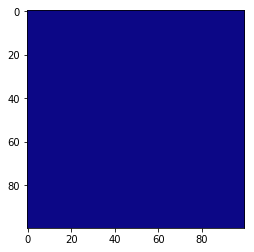

Individual: 1


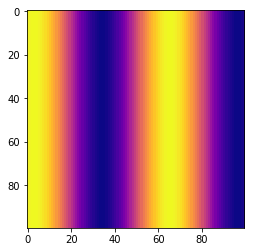

Individual: 2


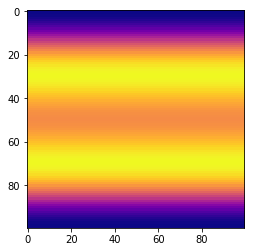

Individual: 3


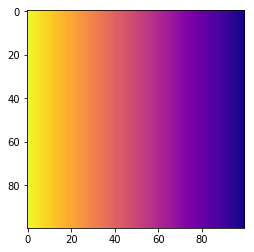

Individual: 4


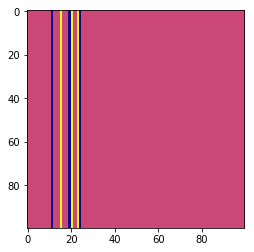

Individual: 5


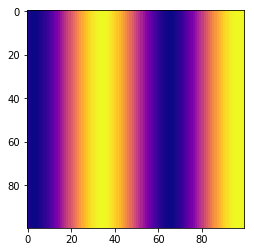

Individual: 6


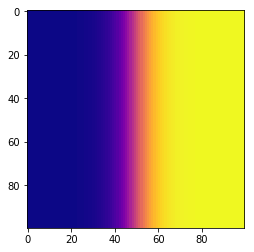

Individual: 7


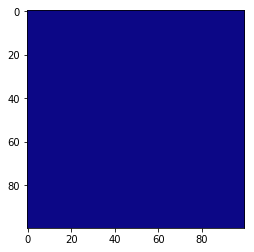

Individual: 8


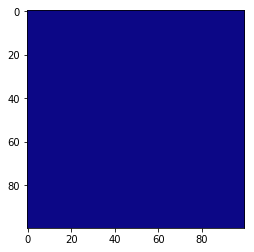

Individual: 9


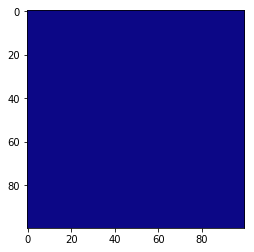

Individual: 10


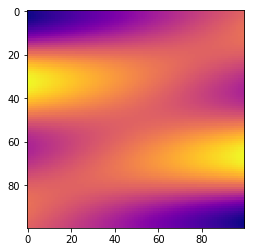

Individual: 11


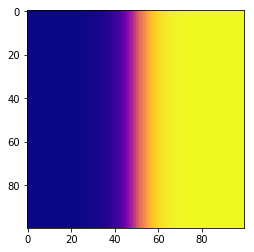

Individual: 12


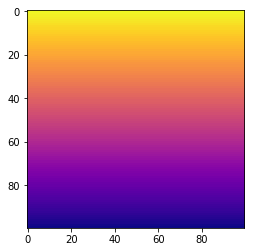

Individual: 13


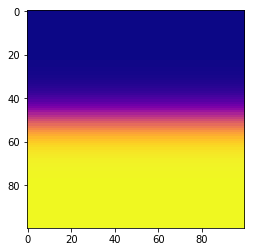

Individual: 14


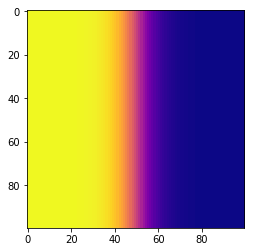

Individual: 15


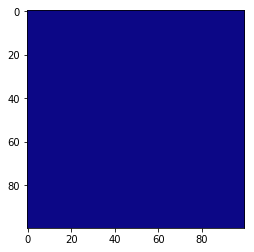

Individual: 16


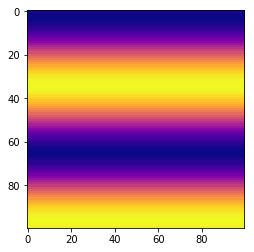

Individual: 17


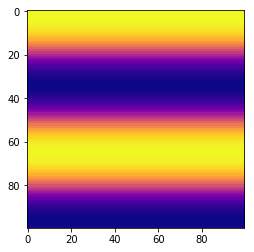

Individual: 18


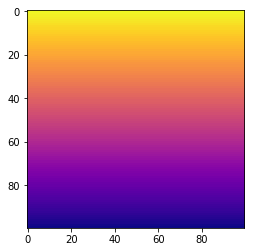

Individual: 19


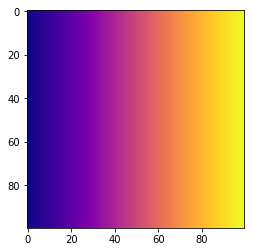

In [5]:
tn1 = GPConstNode(0.2)
tn2 = GPConstNode(1.5)
tn3 = GPConstNode(-1)
tn4 = GPVariableNode(variable_name='x')
tn5 = GPVariableNode(variable_name='y')


fn3 = GPFunctionNode(arg_count=2, func_name="Add", gp_function=lambda x,y: x+y)
fn4 = GPFunctionNode(arg_count=2, func_name="Sub", gp_function=lambda x,y:x-y)
fn5 = GPFunctionNode(arg_count=2, func_name="Mult", gp_function=lambda x,y: x*y)
fn7 = GPFunctionNode(arg_count=1, func_name="Tanh", gp_function=lambda x: np.tanh(x))
fn8 = GPFunctionNode(arg_count=1, func_name="Sin", gp_function=lambda x: np.sin(x))

gp_individuals = []
for i in range(20):
    g = GPIndividual([fn3, fn4, fn5, fn7, fn8], [tn1, tn2, tn3, tn4, tn5], 0.0, max_depth=3)
    gp_individuals.append(g)
    
    print("Individual: {0}".format(i))
    dim_pic = 100
    image_matrix = np.zeros((dim_pic, dim_pic))
    x = y = np.linspace(-5, 5, dim_pic)
    for i in range(dim_pic):
        for j in range(dim_pic):
            image_matrix[i,j] = g.evaluate({'x':x[i],'y':y[j]})

    pyplot.imshow(image_matrix, cmap=pyplot.get_cmap("plasma"))
    pyplot.show()

# Instead of changing the number of hidden layers to get more complexity, we can change the maximum allowed `depth` of a program. Remember these programs are trees, and the depth says how far down we allow the tree to grow. 

Individual: 0


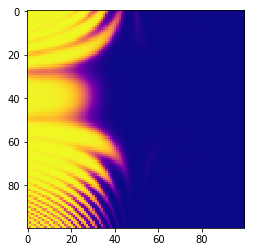

Individual: 1


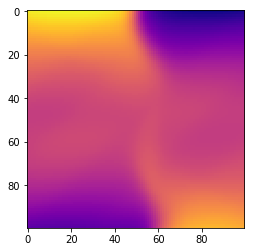

Individual: 2


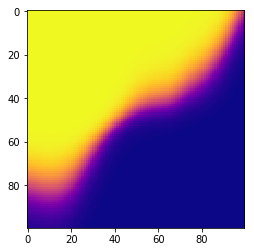

Individual: 3


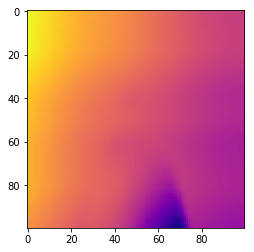

Individual: 4


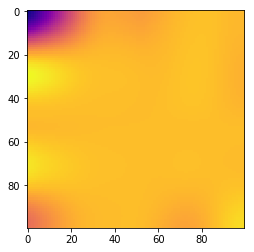

Individual: 5


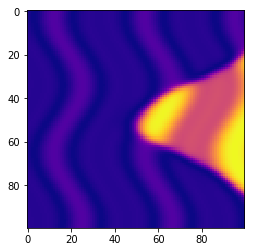

Individual: 6


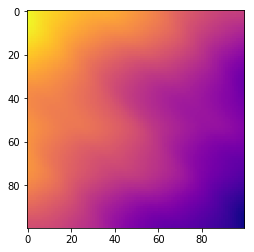

Individual: 7


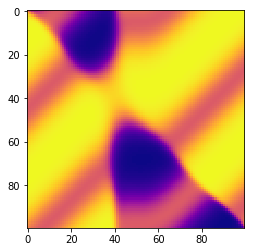

Individual: 8


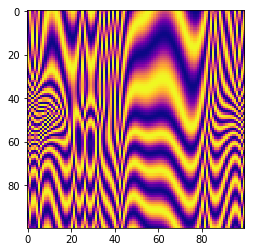

Individual: 9


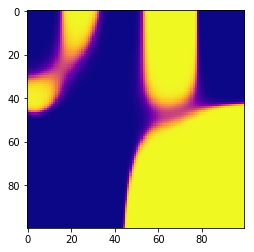

Individual: 10


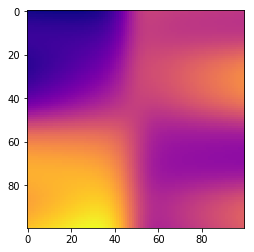

Individual: 11


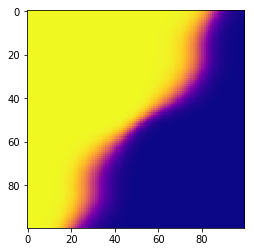

Individual: 12


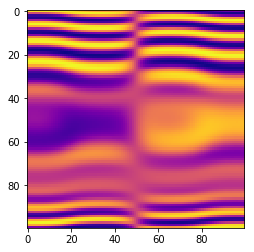

Individual: 13


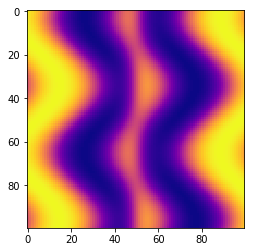

Individual: 14


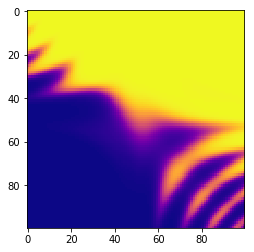

Individual: 15


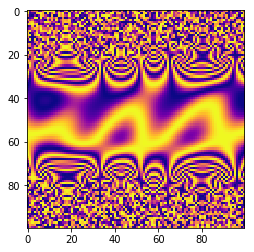

Individual: 16


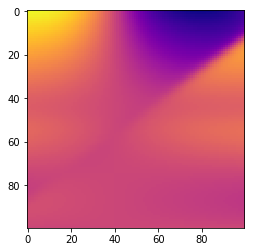

Individual: 17


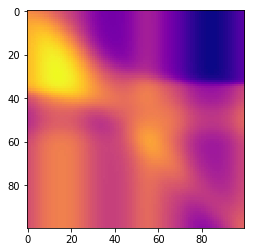

Individual: 18


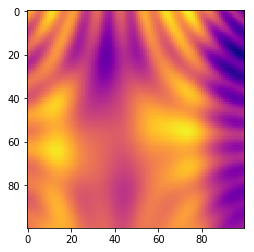

Individual: 19


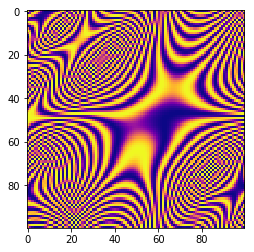

In [7]:
gp_individuals = []
for i in range(20):
    g = GPIndividual([fn3, fn4, fn5, fn7, fn8], [tn1, tn2, tn3, tn4, tn5], 0.0, max_depth=8)
    gp_individuals.append(g)
    
    print("Individual: {0}".format(i))
    dim_pic = 100
    image_matrix = np.zeros((dim_pic, dim_pic))
    x = y = np.linspace(-5, 5, dim_pic)
    for i in range(dim_pic):
        for j in range(dim_pic):
            image_matrix[i,j] = g.evaluate({'x':x[i],'y':y[j]})

    pyplot.imshow(image_matrix, cmap=pyplot.get_cmap("plasma"))
    pyplot.show()